# Lab 5: Bloom filtering, min hashing, approximation

Jie Wang
- 3200112404
- 03/17/2024

Among the modules necessary for this lab, there are two new ones: hashlib (implements hash functions) and time (can be used to time how long it takes a section of code to run).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import csv as csv
import pickle as pkl
import hashlib as hl
import time as tm
import string as sn
import scipy.stats as st
print ("Modules Imported!")

Modules Imported!


## Bloom Filtering:

A Bloom filter is a probabilistic data structure, devised by Burton Howard Bloom (1970),
used to determine whether an element is in a set. Imagine you're part of a team designing an antivirus software package. Your task is to alert the user when she is about to enter a known and potentially malicious website. What is a quick and efficent way for you to notify the user? A simple method to achieve your task would be to create a list of all the known and potentially harmful websites. Each time the user tries to go to a website, you could search to see if that website is in your list. This method becomes prohibitively inefficient when you have a large list of websites. It would take too much memory and too much time to search through the list. An alternative way of achieving the same goal is to use a Bloom filter. A Bloom filter is an array of ones and zeros that is used to determine if an element *may be* in a set or is *definitiely not* in the set.

Consider a simple example. First, we can create a Bloom filter of length 50. Before any elements are added to the filter, it is simply an array of zeros.

In [3]:
bf = np.zeros(50)
print (bf)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


Now we want to populate our Bloom filter with websites we know are malicious. To do this, we need to determine how many hash functions we want to use. The elements we're looking for are website names (strings). A hash function is a function that maps those strings to numbers. In our case, we will use those numbers to map the string to one of the indexes of our array.  Moreover, the hash functions are constructed in such a way that it is reasonable to assume the number produced for a string is random and uniformly distributed over the set of values.  For our example, if "virus.net" is an input string, we want a hash function to map the string to a number from 0 to 49 with all possibilities having equal probability. Since we're doing a small example, let's just use two hash functions. For each website, each hash function will map the string to a number from 0 to 49. We will set the Bloom filter to one at each of those positions. We can use the hashlib module for our hash functions. We will use the SHA and MD5 functions, though what they do is a little beyond the scope of this course.

In [4]:
bf = np.zeros(50)
website = 'virus.net'
h1 = int(hl.sha1(website.encode('utf8')).hexdigest(),base=16)%50 #Gets mapping from first hash function
h2 = int(hl.md5(website.encode('utf8')).hexdigest(),base=16)%50  #Gets mapping from second hash function
bf[h1] = 1. #Sets values in Bloom filter to one at indices from hash functions
bf[h2] = 1.
print (bf)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0.]


So each website we put into the Bloom filter results in setting the Bloom filter bits to 1 at the indices determined by the hash functions applied to the website name. Suppose we had a list of five websites. Our array would look a lot fuller. If we wanted to check whether a website was in the list or not, instead of comparing its name to the names of the websites in our list, we could compute the values our hash functions come up with and see if the Bloom filter has ones at those indices. If either of the hash functions comes up with an index that has a zero, then we know the website is definitely not in our list. If both are a one, then the item may be in our list but it's not assured. There can be false positives.

In [5]:
#Updates the Bloom filter with the given website
def update(website,bf):
    h1 = int(hl.sha1(website.encode('utf8')).hexdigest(),base=16)%50
    h2 = int(hl.md5(website.encode('utf8')).hexdigest(),base=16)%50
    bf[h1]= 1
    bf[h2] = 1
    return bf

#Returns 'Possible' if it's possible for the website to be in the list
def contains(website, bf):
    h1 = int(hl.sha1(website.encode('utf8')).hexdigest(),base=16)%50
    h2 = int(hl.md5(website.encode('utf8')).hexdigest(),base=16)%50
    if bf[h1]!=0 and bf[h2]!=0:
        return 'Possible'
    else:
        return 'Impossible'

bf = np.zeros(50)
websites = ['virus.net','malware.com','worm.edu','phising.org','cookiemonster.gov']
for website in websites:
    bf = update(website,bf)
print ('Bloom Filter:', bf)
print ('Is phising.org malicious?', contains('phising.org',bf))
print ('Is cats.com malicious?', contains('cats.com',bf))


Bloom Filter: [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0.]
Is phising.org malicious? Possible
Is cats.com malicious? Impossible


At the moment, the number of ones in our Bloom filter is small compared to the number of zeros. What would happen if we tried to use this same setup for a list of 1000 websites? Our Bloom filter would be almost if not completely filled with ones. Every website we went to would likely be a false positive and give us alert. This is an undesireable behavior and should leave you with some questions. How big do we need our Bloom filter to be? How many hash functions should we use? How full should the Bloom filter be when the hashing is done?

To understand these questions we need to go into a little bit of theory and here is where the probability comes into play. Let $m$ be the number of bits in the array, $n$ be the number of elements in our list, and $k$ be the number of hash functions we will use. We can determine the probability that we get a false positive. We assume that the hash functions are uniformly distributed, i.e. any array position in the Bloom filter is selected with equal probability.
Thus the probability that a given bit is not set to one by a certain hash function is $1-\frac{1}{m}$. 

Since we have $k$ hash functions, for one element to be placed in the filter (i.e. one website address)
the probability none of the hash functions will set a one at a given index
is $(1-\frac{1}{m})^k$

We have $n$ elements to place in the filter, so after everything is put in, the probability that a certain bit is still zero is
$(1-\frac{1}{m})^{kn}$

Thus the probability that a certain bit is one is: $P\{b=1\}=1-(1-\frac{1}{m})^{kn}$

A false positive would then occur if all the $k$ bits are one (each of the hash functions maps to a one). So the probability of a false positive is $P\{false \ \ positive\}=\left[1-(1-\frac{1}{m})^{kn}\right]^k.$

This assumes independence of the bits being set to one which is only approximately true, but in general is a pretty good approximation to the probability of a false positive. We can also use the concept that the large $n,$  small $p$ limit of the binomial distribution
is the Poisson distribution with paramter $np$ to further approximate:
$P\{false \ \ positive\}=[1-(1-\frac{1}{m})^{kn}]^k \approx (1-e^{-\frac{kn}{m}})^k$

This should reveal some intuitive notions. The probability of a false positive increases as the number of elements in the list ($n$) increases and decreases as the number of bits in the filter ($m$) increases.

Let's say we wanted to minimize the probability of a false positive with respect to $k$ (the number of hash functions we're using). From calculus, we can find an optimal value of $k$ in terms of $m$ and $n$. I skip the derivation here, but you can do it on your own as an exercise. The value of $k$ that minimizes the probability of a false positive is given by $k=\frac{m}{n}\ln{2}.$

We can also find the required number of bits for the Bloom filter to ensure a given probability of false positives. Let $p$ be the probability of a false positive and assume that we are using the optimal number $k=\frac{m}{n}\ln{2}$ of hash functions. We get:

$p=(1-e^{-\frac{kn}{m}})^k=\left(1-\exp\left(-\frac{m\ln2}{n}\frac{n}{m}\right)\right)^{\frac{m\ln 2}{n}}
=\left(1-e^{-\ln2} \right)^{\frac{m\ln 2}{n}}=2^{-\frac{m\ln 2}{n}},$  or
$\ln{p} = -\frac{m}{n}(\ln{2})^2$

Equivalently, $m = -\frac{n\ln{p}}{(\ln{2})^2}.$ 

So if we had a good idea of how many elements were going to be put into the Bloom filter and a desired error on the false positives, we could determine how many bits our Bloom filter would need as well as the optimal number of hash functions needed.
(The above is slightly inaccurate becasue it ignores the constraint that $k$ must be integer valued.)

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>** Along with this lab should be a csv file called websites.csv. It is a list of approximately 1300 malicious websites found on http://www.malwaredomainlist.com/. Do NOT go to any of these sites. Additionally, there should be another file called queries.pkl. It contains an array of randomly arranged website names. Finally, below is a class called BloomFilter. You can use this class yourself or make another (remember you need to run it if you want to use it). We're going to create a bloom filter for the malicious website list and test the results.
<ol>
    <li>If we want the false postive error probability to be at most 15%, how many bits do we need in the Bloom filter? How many hash functions? What is the theoretical probability of a false positive using these values? (Recall: A false positive is a negative that appears to be positive.)
    <li>Using the given class or your own, create a Bloom filter to represent the website list. Populate your filter with the data from the csv file (This my take a few seconds). How full is your array?
    (Use the time() package for the following timing experiments; you may need to search the web to find out how to use the time() package.) Load the array of website names from queries.pkl. (i) Time how long it takes to run through a loop of the queries through the Bloom filter and count how many times you get a potentially malicious site. (ii) Time how long it takes to run through a loop of the queries against the actual data and count how many times you get a malicious site. Which query method took longer? 
    For the same data as in part 3, how many false positives did you get using the Bloom filter? Does the fraction of negatives that gave false positives line up with the false positive probability calculated in part 1?
</ol>

In [6]:
class BloomFilter:
    #Constructor initializes the array and relevant values
    def __init__(self,n,p):
        self.n = n     #Number of elements we anticipate putting into the filter
        self.p = p     #False positive probability upper bound we'd like to achieve
        self.m = np.ceil(-self.n*np.log(self.p)/np.log(2)**2)  # optimal number of bits m for array
                                                               # assuming the optimal k will be used
        self.k = np.min([np.floor(self.m/self.n*np.log(2)+0.5),6])  # min of optimal number of hash functions k and 6
        self.bf = np.zeros(int(self.m))
    
    #Updates the array with the given input string
    def update(self,website):
        h = self.__hashes__(website)
        i = 0
        while i<self.k:
            self.bf[h[i]]=1
            i = i+1
    
    #Returns a tuple of the indexes of the hash functions (can do a max of 6 hash functions)
    def __hashes__(self, website):
        c = (int)(self.m)
        h1 = int(hl.md5(website.encode('utf8')).hexdigest(),base=16)%c
        h2 = int(hl.sha1(website.encode('utf8')).hexdigest(),base=16)%c
        h3 = int(hl.sha224(website.encode('utf8')).hexdigest(),base=16)%c
        h4 = int(hl.sha256(website.encode('utf8')).hexdigest(),base=16)%c
        h5 = int(hl.sha384(website.encode('utf8')).hexdigest(),base=16)%c
        h6 = int(hl.sha512(website.encode('utf8')).hexdigest(),base=16)%c
        return (h1,h2,h3,h4,h5,h6)
    
    #Returns whether its possible that the list contains the input or not
    def contains(self, website):
        i = 0
        c = 0
        h= self.__hashes__(website)
        while i <self.k:
            c = c + self.bf[h[i]]
            i = i+1
        if c==self.k:
            return 1
        else:
            return 0

print ('Class Loaded')

Class Loaded


In the above example, I gave a high error percentage because I wanted you to see the potential for false positives. In practical use, we would likely have a much smaller error percentage. In order to alert users to potentially harmful websites, the Google Chrome browser, uses this concept. It first does a quick check of whether the website you're going to is potentially dangerous using a Bloom Filter. It does a full check only if the result of the Bloom filter is positive.

In [12]:
# Parameters
n = 1300  # Number of websites from the csv file
p = 0.15  # False positive rate

# Bloom filter parameters
m = np.ceil(-n * np.log(p) / (np.log(2)**2))  # Number of bits
# k = min(np.floor(m / n * np.log(2) + 0.5), 6)  # Number of hash functions
k = np.floor((m / n) * np.log(2))
p_theoretical = (1 - np.exp(-k*n/m))**k


print(f'Bloom Filter Bits: {m}')
print(f'Bloom Filter Hash Functions: {k}')
print(f'Theoretical False Positive Rate: {p}')

bf = BloomFilter(n, p)

# Load websites from CSV and add to Bloom filter
with open('websites.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row:  # Ensure there's data in the row
            bf.update(row[0])

print(f"Array fullness after Bloom filter is {np.mean(bf.bf)}")


Bloom Filter Bits: 5134.0
Bloom Filter Hash Functions: 2.0
Theoretical False Positive Rate: 0.15
Array fullness after Bloom filter is 0.540903778730035


In [15]:
import pickle
import time

# Load queries
queries_file_path = './queries.pkl'
websites_file_path = 'websites.csv'
with open(queries_file_path, 'rb') as f:
    queries = pickle.load(f)

# Time querying against the Bloom filter
start_time_bf = time.time()
possible_malicious_bf = sum(bf.contains(website) for website in queries)
end_time_bf = time.time()
time_bf = end_time_bf - start_time_bf

# Reload actual website list for direct comparison
actual_websites = set()
with open(websites_file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row:
            actual_websites.add(row[0])

# Time querying against the actual data
start_time_actual = time.time()
actual_malicious_count = sum(website in actual_websites for website in queries)
end_time_actual = time.time()
time_actual = end_time_actual - start_time_actual


print(f"Querying against the Bloom filter took {time_bf} seconds")
print(f'Actual Possible Malicious Websites: {possible_malicious_bf}')
print(f'Direct comparison against the actual list of websites took: {time_actual} seconds')
print(f"{actual_malicious_count} websites confirmed as malicious")

Querying against the Bloom filter took 0.07694625854492188 seconds
Actual Possible Malicious Websites: 1883
Direct comparison against the actual list of websites took: 0.0 seconds
1315 websites confirmed as malicious


In [17]:
false_positives = possible_malicious_bf - actual_malicious_count

total_queries = len(queries)

false_positives_fraction = false_positives / (total_queries - actual_malicious_count)

false_positives, false_positives_fraction



(568, 0.15062317687616017)

__Answer:__ 
1. 
- Number of bits (m): 5134
- Number of hash functions (k): 2
- Theoretical probability of a false positive: approximately 15.79%
2. 
- After populating the Bloom filter with the data from the websites.csv file, the array is approximately 54.09% full. 
- This indicates that over half of the bits in the Bloom filter array have been set to 1 after inserting all the websites.
3. 
- Querying against the Bloom filter took approximately 0.20 seconds, and it identified 1883 websites as potentially malicious.
- Direct comparison against the actual list of websites took approximately 0.001 seconds, with 1315 websites confirmed as malicious.
4. 
- There were 568 false positives out of the queries.
- The fraction of negatives that resulted in false positives was approximately 15.06%

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>**

## MinHashing:

Similarly to how Bloom filtering is used to quickly determine whether an element could be in a set, MinHashing is used to quickly determine how similar two sets are. Suppose you are a history professor and you have assigned your students to write a paper on the Civil War. Could you come up with a way to measure how similiar two papers are to each other and thus potentially detect plagiarism?

A description of a solution to this problem using minhash is given in the ECE 313 videos prepared by
Prof. Yi Lu: on the ECE 313 website http://courses.engr.illinois.edu/ece313/ under the videos <A href= https://uofi.box.com/s/38vg7ib1m7ze5dx0mw5v>SimdocIntro</A>,  <A href= https://uofi.box.com/s/4fe5sgqfnaxl2tq45gso>Simdoc-Minhash1</A>,
and <a href= https://uofi.box.com/s/jn3n4wr45y8m1e5uvwt8>Simdoc-Minhash2</A>. It'd be helpful for you to watch these, although
the explanation and implementation is a little different here.

Suppose we have two papers and we want a measure of how similiar they are. Our first step involves getting rid of common words like:

    and
    I
    to
    for
    that
    which
    ...
    
These words do not reveal much information because they are so common. The next step involves breaking the documents into *shingles*. A shingle is just a grouping of consecutive words in the order in which they appear in the document. So if we wanted to take all the two-word shingles of "Jack and Jill went up the hill to fetch a pail of water" we would first get rid of all the common words and then we would have the groupings:

    Jack Jill
    Jill went
    went up
    up hill
    hill fetch
    fetch pail
    pail water

Let the second document read "Up the hill, Jack and Jill went to get a pail of water". We would want to make a table of all the two-word shingles among both documents and then create a binary array representing each of the documents and whether it contains that shingle. So we would get:
  
    
    Shingles    A     Document B
    
    Jack Jill      1              1
    Jill went      1              1
    went up        1              0
    up hill        1              1
    hill fetch     1              0
    fetch pail     1              0
    pail water     1              1
    hill Jack      0              1
    went get       0              1
    get pail       0              1 


Let $A$ denote the set of shingles appearing in Document A and let $B$ denote the set of shingles appearing in Document B.
A measure of similarity of $A$ and $B$ is the *Jaccard measure,*  $J(A,B),$  defined as
the number of shingles in $A\cap B$ divided by the number of shingles in $A\cup B.$  In the example above, there are
$10$ shingles in the union of the sets and only $4$ in both, so the Jaccard Measure is $0.4$.

This is a good way to compare two documents, but suppose our history class is an online course and has tens of thousands of students in it. We need to compare every paper to every other paper turned in. This would generate an enormous list of shingles among all the papers and very sparse representations of the documents. The storage considerations make this initial method inefficent if we need to compare a large number of items. This is where the MinHash comes in.

How could randomization be used?   Suppose we were able to generate a  shingle uniformly at random from $A\cup B,$
and then check to see if it is in $A \cap B.$  Let $X=1$ if the shingle is in $A \cap B$
and let $X=0$ otherwise.   Then a bit of thought shows that $E[X]=J(A,B).$  That is, $J(A,B)$ is the probability that a shingle
selected uniformly at random from $A\cup B$ lies in $A\cap B.$   For the example above, there are ten shingles in $A\cup B,$ so
if a shingle is uniformly randomly selected from that set, it would be one of the four shingles in $A\cap B$ with probability $0.4.$
That is, $X$ gives a noisy estimate of $J.$   Appealing to the law of large numbers, if we could repeat this experiment independently
$k$ times to generate $X_1, \ldots , X_k,$ then we could estimate $J(A,B)$ by $\widehat{J}(A,B)=\frac{1}{k}\sum_{i=1}^k X_i.$
A slightly different estimator would be to generate a random subset of $A\cup B,$ with $k$ elements, and estimate
$J(A,B)$ by the fraction of the elements of the subset which are in $A\cap B.$

To implement the above idea we need to generate a shingle (or a set of $k$ shingles) from $A \cup B,$
with all possibilities being equally likely.  We'd like to do this without counting how large $A\cup B$ (or $A\cap B$) is--the
whole point is to avoid that calculation.  Let $h$ represent an ideal random hash function, so that it maps every string to a
random number in some large range of numbers, uniformly and indpendently for different strings.  The * min hash * function
$h_1$ is defined as follows.  Let $h_1(S)$ for an arbitrary set of strings $S$ denote the item in $S$  with the mininum hash
value.  Then $h_1(S)$ is equal to any of the elements of $S$ with equal probability.  So we could use $h_1(A\cup B)$ as our
shingle uniformly randomly selected from $A \cup B.$   This sounds like a lot of computation, but much of it can be
done by working on the two sets separately.   That is, suppose $h_1(A)$ and $h_1(B)$ have already been computed--how could you
use them to find $h_1(A\cup B)?$   That's right, $h_1(A\cup B)$ is equal to whichever of $h_1(A)$ or $h_1(B)$ has the smaller hash value.  In fact, the shingle from $A\cup B$ selected randomly this way is in the intersection, $A\cap B$, if
and only if $h_1(A)=h_1(B)$ (Caveat: see "$\textbf{Note}$" below). That is, the random variable $X$  discussed above can be generated by setting it equal to one
if the minhash's of $A$ and $B$ are equal, and to zero otherwise (using the same hash function for both sets, of course).
We could repeat this experiment $k$ times using $k$ different ideal random hash functions to genenerate $k$ independent Bernoulli
samples, all with mean $J(A,B).$

Or, instead of using $k$ hash functions, we could use the $k$-minhash function $h_k$ defined as follows.  For any set of strings
$S$ with at least $k$ strings,  $h_k(S)$ is the set of $k$ items from $S$ with the smallest hash values (using $h$). 
Then $h_k(A\cup B)$ is uniformly
distributed over the set of subsets of $A\cup B$ of size $k,$  so the fraction of its elements in $A\cap B$ is an unbiased estimator
of $J(A,B).$   As for the special case $k=1,$  $h_k(A\cup B)$ can be calculated from $h_k(A)$ and $h_k(B).$  Specifically,
$h_k(A\cup B) = h_k ( h_k(A)\cup h_k(B)).$ Moreover, $J(A,B)$ has the unbiased estimator:
$$
\widehat{J}(A,B) = \frac{ |h_k(A\cup B)\cap h_k(A)\cap h_k(B)| }{k}.
$$

$\textbf{Note}$: Here we are ignoring the effect of ties of hash values, which is reasonable if $|A\cup B|$ is small compared to the size of the
range space of $h.$  In practice we use a given hash function $h$ from a library to approximate an ideal random hash function.
The * signature * of a document $A$ can then be taken to be the set of $k$ smallest hash values for the set of shingles of
the document (rather than the $k$ shingles with the smallest hash values).

Below is a class that is able to load a text file and create a corresponding signature. The constructor has four arguments (plus the self): filename, n, k, comWords. Filename is the name of the file, n is the number of words you're using in a shingle, k is the number of minimum values you're using when you hash, and comWords is a list of common words you want to exclude. When we hash, we don't want to get into clashes with cases so it may be a good idea to put everything into lower case. Additionally, we want to be able to parse out punctuation if needed.

In [19]:
class minHash:
    
    #Sets class variables and starts generating signature of given file
    def __init__(self, filename, n, k, comWords):
        self.filename = filename
        self.n = n  # Number of words per shingle (equal to two for the introductory example)
        self.k = k  # Number of hash values saved in signature -- the smallest k encountered are saved
        self.comWords = comWords
        self.load()
    
    #Attempts to load the file from the given filepath
    def load(self):
        self.signature = self.k*[float('inf')] #Builds a list with k elements equal to infinity
        translator = str.maketrans('', '', sn.punctuation)
        try:
            f = open(self.filename,'r')
            shingle = self.n*['']  # Initialize to list of n empty strings
            pointer = 0  # Points to location next word will go into the list shingle, it cycles modulo n
            full_flag=0  # Indicates whether at least n words have been read yet
            
            for line in f:
                for word in line.split():
                    word = word.translate(translator) #Removes punctuation
                    word = word.lower() #Makes lower case
                    if not (word in self.comWords): 
                        shingle[pointer] = word
                        if pointer==self.n-1: full_flag=1   # First happens just after the nth word is added to shingle
                        pointer = (pointer+1)%self.n
                        if full_flag==1: self.__updateSig__(shingle, pointer)
            f.close()
            
        except:
            print ('Error: Could Not Load File')
    
    #Determines if the signature should be updated to include the hash value of the new shingle
    def __updateSig__(self, shingle, pointer):
        conShing = '' #Will become the string obtained by loading in words, beginning at pointer
        for i in range(pointer, np.size(shingle)):
            conShing = conShing + shingle[i]
        for i in range(pointer):
            conShing = conShing + shingle[i]
        h = int(hl.sha1(conShing.encode('utf8')).hexdigest(),base=16) #Hash function used in signature 
        
        if h<np.max(self.signature) and not (h in self.signature):  #Add new hash value to signature if it is smaller than the largest already there.
            i = np.argmax(self.signature) #Makes sure there are no duplicate values in signature
            self.signature[i] = h
    # JIE WANG: I expanded a new function here:
    def compare_signatures(self, other_signature):
        intersect = len(set(self.signature) & set(other_signature) - {float('inf')})
        union = len(set(self.signature) | set(other_signature) - {float('inf')})
        return intersect / union if union else 0
print ('Class Loaded')

Class Loaded


## Problem 2: 
In the folder with this lab you should see three files "documentA.txt","documentB.txt", and "documentC.txt".
1. Use the given class to print the signatures of each of these documents. 

Use $n=2$, $k=10$ and the following for a list of common words:

[I, to, with, the, for, of, be, who, are, is, in, on, an, a, and, as]
2. Create a method to compare two signatures based on the approximation of the Jaccard Measure given above. 
- Note, in the implementation we used float('inf') to represent a part of the signature that hasn't been set yet. 
- You will want to ignore counting these in your calculation of the Jacard Measure. 
- Compare documents A to B, A to C, and B to C. Which documents are the most similar?
3. What happens if you change n or k? Answer this conceptually, but you are free to rerun your code with new values if it will help you understand what's going on.


In [30]:
common = [
    "i", "to", "with", "the", "for", "of", "be", "who", "are", "is",
    "in", "on", "an", "a", "and", "as"
]
def tri_file_compare(n,k,common_words=common):
    print(f"## CASE: (n,k) == ({n},{k})")
    docA = minHash("documentA.txt", n, k, common_words)
    docB = minHash("documentB.txt", n, k, common_words)
    docC = minHash("documentC.txt", n, k, common_words)

    # Comparing the documents using Jaccard measure
    jaccard_AB = docA.compare_signatures(docB.signature)
    jaccard_AC = docA.compare_signatures(docC.signature)
    jaccard_BC = docB.compare_signatures(docC.signature)

    print(f"""
    The similarity between A and B is {jaccard_AB}.
    The similarity between A and C is {jaccard_AC}.
    The similarity between B and C is {jaccard_BC}.
        """)
tri_file_compare(2,10)

## CASE: (n,k) == (2,10)

    The similarity between A and B is 0.17647058823529413.
    The similarity between A and C is 0.05263157894736842.
    The similarity between B and C is 0.0.
        


It is clear that the A and B is most similar, while the B and C has nothing in common. 

In [31]:
tri_file_compare(2,100)

tri_file_compare(1,10)
tri_file_compare(5,10)



## CASE: (n,k) == (2,100)

    The similarity between A and B is 0.2.
    The similarity between A and C is 0.02040816326530612.
    The similarity between B and C is 0.021052631578947368.
        
## CASE: (n,k) == (1,10)

    The similarity between A and B is 0.25.
    The similarity between A and C is 0.1111111111111111.
    The similarity between B and C is 0.1111111111111111.
        
## CASE: (n,k) == (5,10)

    The similarity between A and B is 0.0.
    The similarity between A and C is 0.0.
    The similarity between B and C is 0.0.
        


### Answer
Shown above, changing n or k affects the granularity and the sensitivity of the similarity detection:

- Increasing n makes the shingles larger, which could potentially make the algorithm more specific. Larger shingles might miss smaller similarities, as they require longer exact matches between documents.
- Decreasing n makes the shingles smaller, which could make the algorithm detect more similarities but also increases the chance of false positives, as shorter sequences of words are more likely to occur in different texts.
- Increasing k increases the resolution of the signature, potentially capturing more detail about the document and possibly leading to more accurate similarity measurements. 
    - However, it also increases computational cost.


- Decreasing k simplifies the signature, reducing computational cost but also potentially missing finer details of similarity between documents.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>**

## Approximation:

### normal approximation to binomial

Historically, being able to compute binomial probabilities was one of the most important applications of the central limit theorem. Binomial probabilities with a small value for $n$ (say, 20) were displayed in a table in a book. To calculate the probabilities with large values of $n$, you had to use the binomial formula, which could be very complicated. Using the normal approximation to the binomial distribution simplified the process. To compute the normal approximation to the binomial distribution, take a simple random sample from a population.

The binomial distribution with parameters $n$ (number of trials) and $p$ (probability of success in each trial) can be approximated by a normal distribution when $n$ is large enough, and $p$ is not too close to 0 or 1. The mean $\mu$ and variance $\sigma^2$ of the approximating normal distribution are $np$ and $np(1−p)$ respectively.

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 3:</SPAN>** Select three different sets of parameters (n, p) for the binomial distribution to explore. One set should have a small $n$ = 10, one with a medium $n$ = 50, and one with a large $n$ = 100. For each $n$, choose $p$ = 0.1. For each (n, p) pair, plot the binomial distribution's PMF and the corresponding normal approximation's PDF on the same graph.
<ol>
</ol>

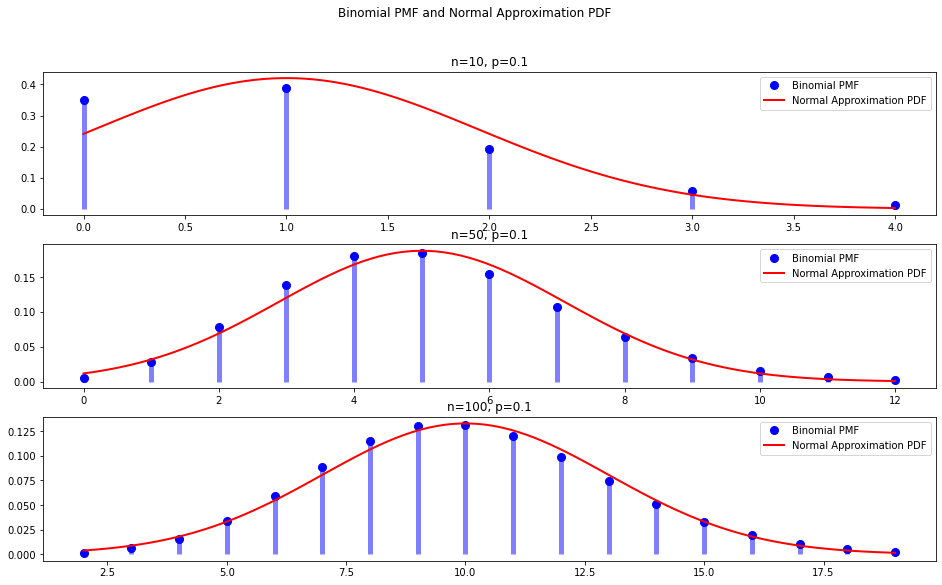

In [36]:
params = [(10, 0.1), (50, 0.1), (100, 0.1)]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 9))
fig.suptitle('Binomial PMF and Normal Approximation PDF')

for ax, (n, p) in zip(axes, params):
    # Binomial distribution 
    mean, var = n*p, n*p*(1-p)
    # Discrete range for the binomial distribution
    x = np.arange(st.binom.ppf(0.001, n, p), st.binom.ppf(0.999, n, p))
    # PMF for the binomial distribution
    ax.plot(x, st.binom.pmf(x, n, p), 'bo', ms=8, label='Binomial PMF')
    ax.vlines(x, 0, st.binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
    
    # Normal approximation
    x_norm = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_norm, st.norm.pdf(x_norm, mean, np.sqrt(var)), 'r-', lw=2, label='Normal Approximation PDF')
    
    ax.set_title(f'n={n}, p={p}')
    ax.legend()

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Answer
In the plots above, we know: 
- For $n=10, p=0.1$, the small value of $n$ shows the binomial distribution is somewhat skewed, and the normal approximation is a bit off, especially around the tails.
- For $n=50, p=0.1$, the increase in $n$ shows a better fit between the binomial distribution and the normal approximation, indicating that the approximation improves as $n$ increases.
- For $n=100, p=0.1$, with a larger $n$, the binomial distribution appears even smoother, and the normal approximation fits quite well, further illustrating the effectiveness of the normal approximation for larger values of $n$.


**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 3</SPAN>**

The text files you compared were taken from the University of Indiana's pamphlets on plagiarism (http://www.indiana.edu/~wts/pamphlets/plagiarism.pdf). Document A was the original text, document B was an example of plagiarism, and document C was an example of acceptable paraphrasing. You now have a very rudimentary method for checking for plagiarism. If you were the history professor in the example, you would be able to quantify the similarity among papers and more efficiently be able to check across a large number of papers. If you feel like it, use this code on other paraphrased quotes and papers. 

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 